In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nptdms import TdmsFile

In [2]:
file_path = '../data/250516_05.tdms'

tdms = TdmsFile.read(file_path)

print("✅ Available groups and channels:")
group_channel_map = {}
for grp in tdms.groups():
    name = grp.name
    channels = [ch.name for ch in grp.channels()]
    group_channel_map[name] = channels
    print(f" - Group: {name}")
    for ch in channels:
        print(f"    • {ch}")

✅ Available groups and channels:
 - Group: Datas
    • Time (ms)
    • Reference Position X
    • Reference Position Y
    • Measured Position X
    • Measured Position Y
    • Reference Tension L
    • Reference Tension R
    • Reference Tension T
    • Measured Tension L
    • Measured Tension R
    • Measured Tension T
    • RBF1
    • RBF2
    • RBF3
    • Trajectory
    • Performance
    • Force X
    • Force y
    • Damp1
    • Damp2
    • Damp3



▶ Using group: Datas


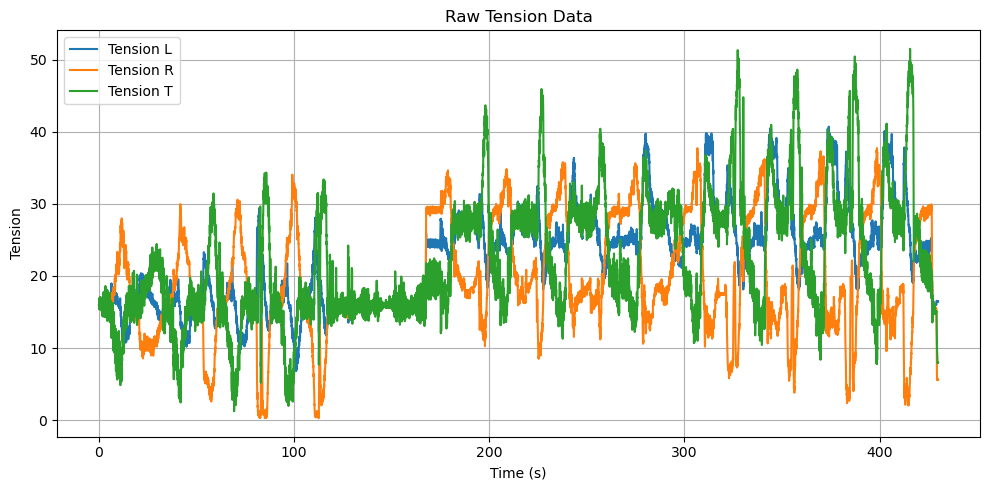

In [4]:
# 2) 사용할 그룹 선택
group = 'Datas' if 'Datas' in group_channel_map else list(group_channel_map.keys())[0]
print(f"\n▶ Using group: {group}")

# 3) 채널값 추출
ten_l = tdms[group]['Measured Tension L'][:]
ten_r = tdms[group]['Measured Tension R'][:]
ten_t = tdms[group]['Measured Tension T'][:]

# 4) 시간 축 생성 (sample_rate = 50 Hz)
time = np.arange(len(ten_l)) / 50

# 5) 시각화
plt.figure(figsize=(10,5))
plt.plot(time, ten_l, color='C0', label='Tension L')
plt.plot(time, ten_r, color='C1', label='Tension R')
plt.plot(time, ten_t, color='C2', label='Tension T')
plt.title('Raw Tension Data')
plt.xlabel('Time (s)')
plt.ylabel('Tension')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

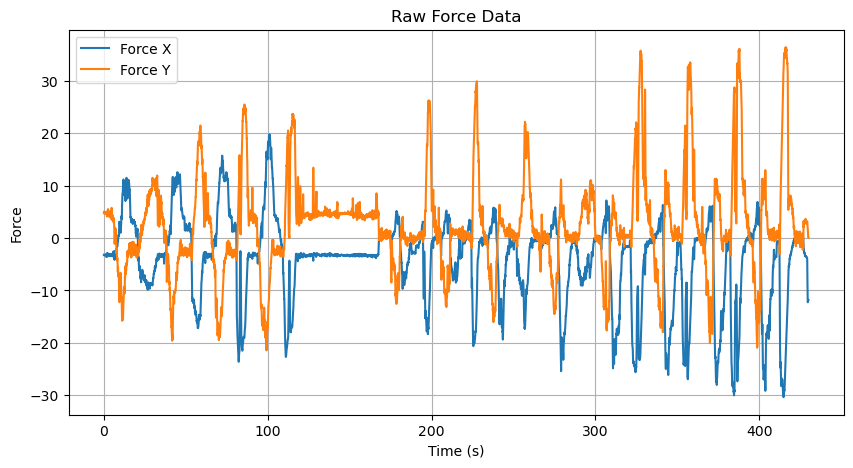

In [5]:
# 채널값 추출 (스케일 적용)
fx = tdms[group]['Force X'][:]
fy = tdms[group]['Force y'][:]
time = np.arange(len(fx)) / 50  # sample_rate=50

plt.figure(figsize=(10,5))
plt.plot(time, fx, color='C0', label='Force X')      # 파란색
plt.plot(time, fy, color='C1', label='Force Y')      # 주황색
plt.title('Raw Force Data')
plt.xlabel('Time (s)'); plt.ylabel('Force')
plt.legend(); plt.grid(True)
plt.show()


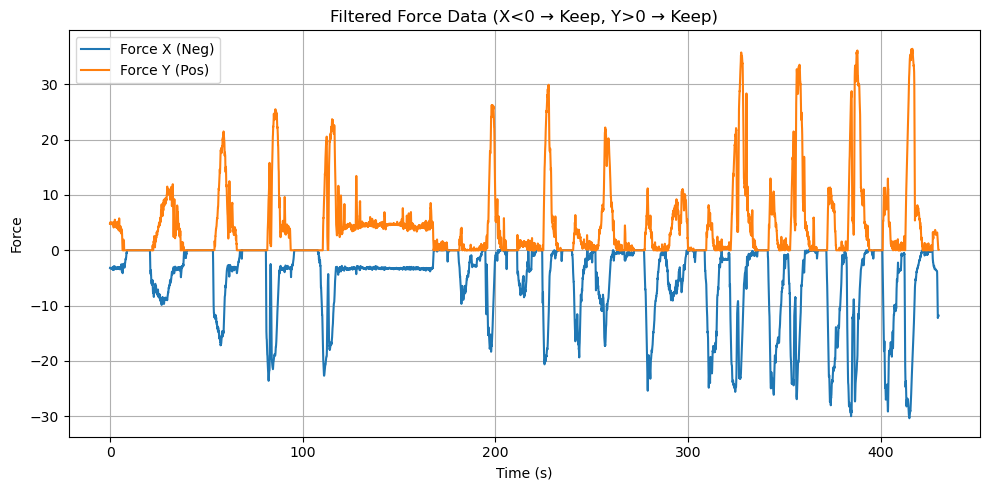

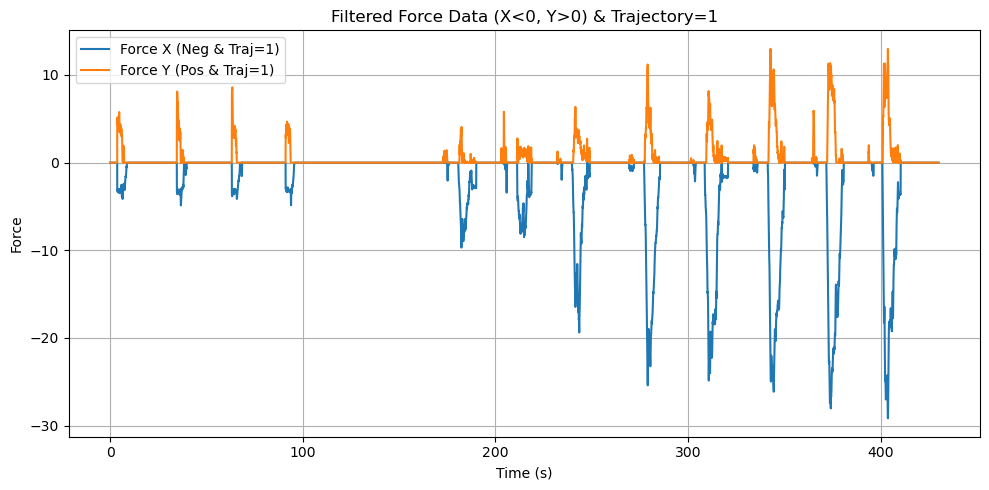

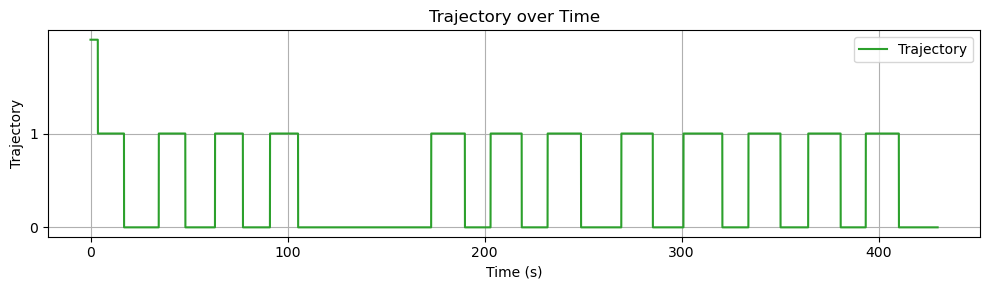

In [6]:
# 2) Force X<0, Force Y>0 필터링 & 시각화 (C0/C1 색상)
fx_neg = np.where(fx < 0, fx, 0)
fy_pos = np.where(fy > 0, fy, 0)

plt.figure(figsize=(10,5))
plt.plot(time, fx_neg, color='C0', label='Force X (Neg)')  # 파란색
plt.plot(time, fy_pos, color='C1', label='Force Y (Pos)')  # 주황색
plt.title('Filtered Force Data (X<0 → Keep, Y>0 → Keep)')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) #2에서 만든 fx_neg, fy_pos에 Trajectory=1 마스크 적용 & 시각화
traj = tdms[group]['Trajectory'][:]    # Trajectory 로드
mask = (traj == 1)                     # Traj=1 위치

# Traj=1 아닌 곳은 0으로 (혹은 np.nan으로 할 수도 있음)
fx_neg_traj = np.where(mask, fx_neg, 0)
fy_pos_traj = np.where(mask, fy_pos, 0)

plt.figure(figsize=(10,5))
plt.plot(time, fx_neg_traj, color='C0', label='Force X (Neg & Traj=1)')
plt.plot(time, fy_pos_traj, color='C1', label='Force Y (Pos & Traj=1)')
plt.title('Filtered Force Data (X<0, Y>0) & Trajectory=1')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(time, traj, color='C2', label='Trajectory')
plt.title('Trajectory over Time')
plt.xlabel('Time (s)')
plt.ylabel('Trajectory')
plt.yticks([0, 1])
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

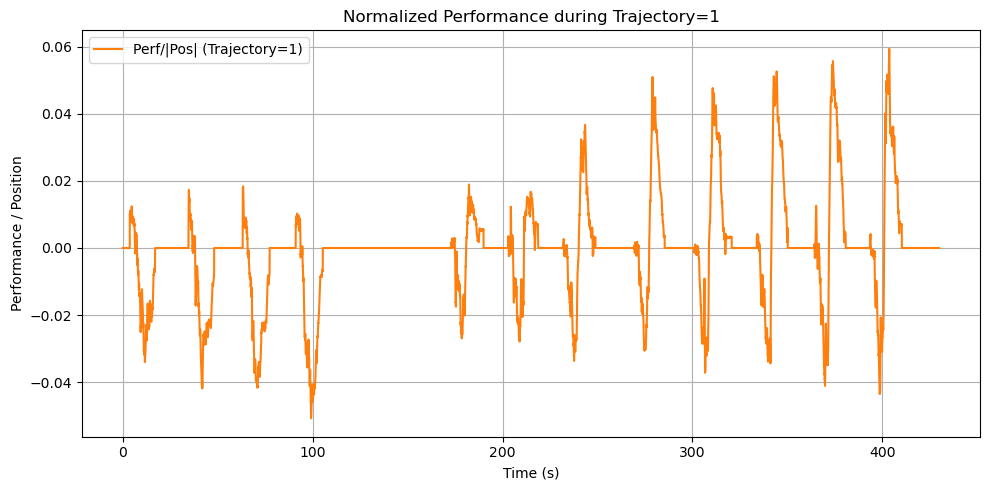

In [7]:
# 2) Performance & Position(X,Y) 로드 → 정규화 → Raw 시각화
perf_raw = tdms[group]['Performance'][:]            # 원본 Performance
pos_x = tdms[group]['Measured Position X'][:]       # X 위치
pos_y = tdms[group]['Measured Position Y'][:]       # Y 위치

# 위치 벡터 크기 계산
pos_mag = np.sqrt(pos_x**2 + pos_y**2)

# 0 나눗셈 방지: 0인 곳은 nan으로
pos_safe = np.where(pos_mag == 0, np.nan, pos_mag)

# 정규화
perf = perf_raw / pos_safe

# 시간 축
time = np.arange(len(perf)) / 50                    # sample_rate = 50 Hz

# 3) Trajectory=1 구간만 마스킹하여 시각화
traj = tdms[group]['Trajectory'][:]          # Trajectory 로드
mask = (traj == 1)                           # Traj=1 위치만 True

# Traj=1 구간만 perf, 나머지는 0 또는 np.nan 처리
perf_traj = np.where(mask, perf, 0)

plt.figure(figsize=(10,5))
plt.plot(time, perf_traj, color='C1', label='Perf/|Pos| (Trajectory=1)')
plt.title('Normalized Performance during Trajectory=1')
plt.xlabel('Time (s)')
plt.ylabel('Performance / Position')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


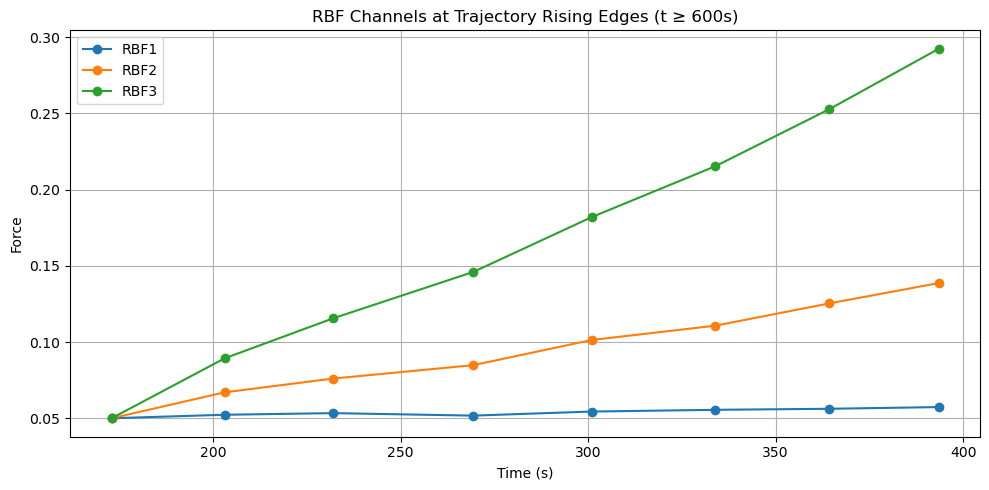

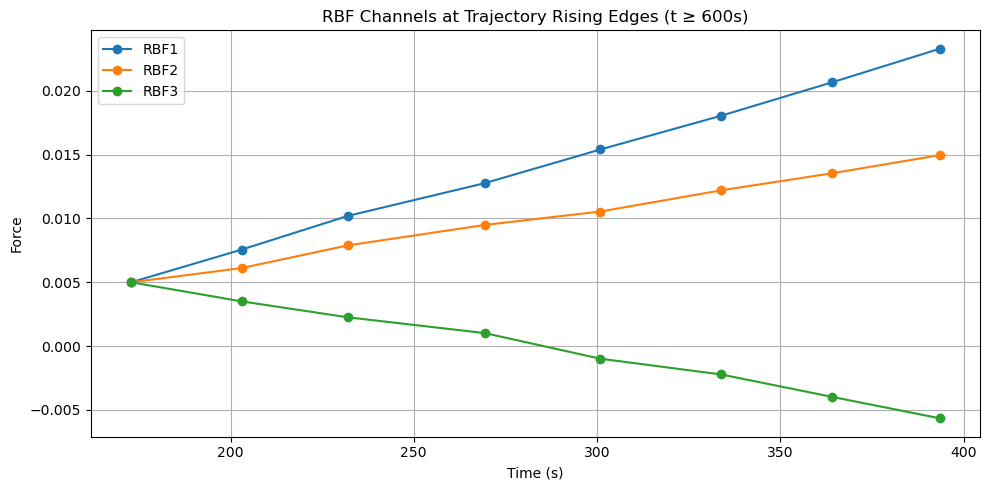

In [15]:
# 2) RBF 채널 & Trajectory, 시간축
w1   = tdms[group]['RBF1'][:] 
w2   = tdms[group]['RBF2'][:]
w3   = tdms[group]['RBF3'][:]
traj = tdms[group]['Trajectory'][:]
time = np.arange(len(w1)) / 50   # sample_rate = 50 Hz

# 3) Trajectory rising edge 인덱스 (0→1)
rising_idx = np.where((traj[:-1] == 0) & (traj[1:] == 1))[0] + 1

# 4) 600초 이후의 rising edge만
mask600 = time[rising_idx] >= 100
rising_idx = rising_idx[mask600]

# 5) 해당 시점의 RBF 값들
t_rise = time[rising_idx]
w1_rise = w1[rising_idx]
w2_rise = w2[rising_idx]
w3_rise = w3[rising_idx]

# 6) 플롯: 점으로 표시하고 직선으로 연결
plt.figure(figsize=(10,5))
plt.plot(t_rise, w1_rise, '-o', color='C0', label='RBF1')
plt.plot(t_rise, w2_rise, '-o', color='C1', label='RBF2')
plt.plot(t_rise, w3_rise, '-o', color='C2', label='RBF3')

plt.title('RBF Channels at Trajectory Rising Edges (t ≥ 600s)')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) RBF 채널 & Trajectory, 시간축
w1   = tdms[group]['Damp1'][:] 
w2   = tdms[group]['Damp2'][:]
w3   = tdms[group]['Damp3'][:]
traj = tdms[group]['Trajectory'][:]
time = np.arange(len(w1)) / 50   # sample_rate = 50 Hz

# 3) Trajectory rising edge 인덱스 (0→1)
rising_idx = np.where((traj[:-1] == 0) & (traj[1:] == 1))[0] + 1

# 4) 600초 이후의 rising edge만
mask600 = time[rising_idx] >= 100
rising_idx = rising_idx[mask600]

# 5) 해당 시점의 RBF 값들
t_rise = time[rising_idx]
w1_rise = w1[rising_idx]
w2_rise = w2[rising_idx]
w3_rise = w3[rising_idx]

# 6) 플롯: 점으로 표시하고 직선으로 연결
plt.figure(figsize=(10,5))
plt.plot(t_rise, w1_rise, '-o', color='C0', label='RBF1')
plt.plot(t_rise, w2_rise, '-o', color='C1', label='RBF2')
plt.plot(t_rise, w3_rise, '-o', color='C2', label='RBF3')

plt.title('RBF Channels at Trajectory Rising Edges (t ≥ 600s)')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

